<a href="https://colab.research.google.com/github/KeremAydin98/n-beats/blob/main/N_Beats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [ ]:
!kaggle datasets download -d arashnic/learn-time-series-forecasting-from-gold-price

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("learn-time-series-forecasting-from-gold-price.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import pandas as pd
gold_df = pd.read_csv("gold_price_data.csv",parse_dates=["Date"],index_col=["Date"])

In [ ]:
gold_df.head()

,Value
Date,
1970-01-01,35.2
1970-04-01,35.1
1970-07-01,35.4
1970-10-01,36.2
1971-01-01,37.4


In [ ]:
import matplotlib.pyplot as plt

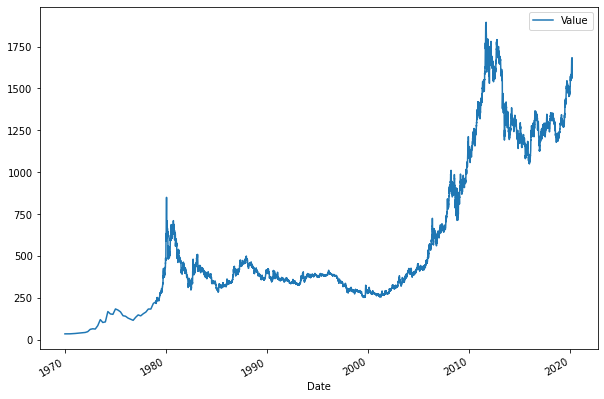

In [ ]:
gold_df.plot(figsize=(10,7))
plt.show()

In [ ]:
len(gold_df)

10787

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

In [ ]:
def get_labelled_windows(x, horizon=HORIZON):

  return x[:,:-horizon], x[:,-horizon:]

In [ ]:
import numpy as np

In [ ]:
x = [1,2,3,4,5,6,7,8]
get_labelled_windows(np.expand_dims(x,axis=0))

(array([[1, 2, 3, 4, 5, 6, 7]]), array([[8]]))

In [ ]:
 np.expand_dims(np.arange(WINDOW_SIZE + HORIZON),axis=0).transpose()

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]])

In [ ]:
def get_full_windows(dataset, window_size = WINDOW_SIZE, horizon = HORIZON):

  """
  We will transform the dataset into windowed arrays by using numpy indexing
  """

  # Create one windows step
  window_steps = np.expand_dims(np.arange(window_size + horizon),axis=0)

  # Calculate the windows indexes in nested numpy arrays
  window_indexes = window_steps + np.expand_dims(np.arange(len(dataset) - (window_size + horizon -1)),axis=0).transpose()

  # Create the windowed array of the particular dataset by indexing
  windowed_array = dataset[window_indexes]

  # Slice it into window and target so that we can turn forecast problem into a supervised regression problem
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
prices = gold_df["Value"].to_numpy()
timesteps = gold_df.index.to_numpy()

In [ ]:
prices[:10]

array([35.2, 35.1, 35.4, 36.2, 37.4, 38.9, 40.1, 42. , 43.5, 48.3])

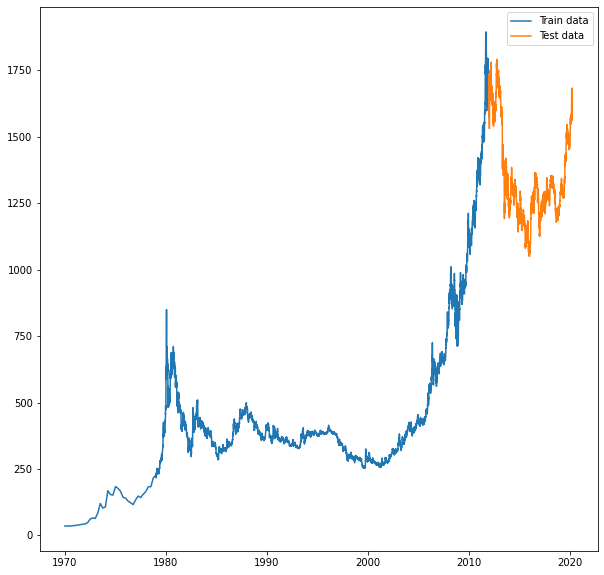

In [ ]:
# Split data into train and test results to plot it
split_size = int(len(prices) * 0.8)
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

plt.figure(figsize=(10,10))
plt.plot(X_train, y_train, label="Train data")
plt.plot(X_test, y_test, label="Test data")
plt.legend()
plt.show()

In [ ]:
full_windows, full_labels = get_full_windows(prices)

In [ ]:
# Print the result to check if the function works or not
for i in range(3):

  print(f"Window {i}: {full_windows[i]} --> target {i}: {full_labels[i]}\n")

Window 0: [35.2 35.1 35.4 36.2 37.4 38.9 40.1] --> target 0: [42.]

Window 1: [35.1 35.4 36.2 37.4 38.9 40.1 42. ] --> target 1: [43.5]

Window 2: [35.4 36.2 37.4 38.9 40.1 42.  43.5] --> target 2: [48.3]



In [ ]:
# Split data into train and test results 
split_size = int(len(prices) * 0.8)
train_windows, train_labels = full_windows[:split_size],full_labels[:split_size]
test_windows, test_labels = full_windows[split_size:], full_labels[split_size:]

In [ ]:
import tensorflow as tf

In [ ]:
x_train = tf.data.Dataset.from_tensor_slices(train_windows)
y_train = tf.data.Dataset.from_tensor_slices(train_labels)

train_dataset = tf.data.Dataset.zip((x_train, y_train))

x_test = tf.data.Dataset.from_tensor_slices(test_windows)
y_test = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((x_test, y_test))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
len(train_windows),len(train_labels),len(test_windows)

(8629, 8629, 2151)

In [ ]:
# Training forecast model will have many ups and downs therefore we need a checkpoint to get the optimal model
def create_model_checkpoint(model_name):

  path_name="model_checkpoint/"

  return tf.keras.callbacks.ModelCheckpoint(filepath=path_name+model_name,
                                            monitor="val_loss",
                                            save_best_only=True)

In [ ]:
import tensorflow as tf

# Model Experiments:

1. Baseline model(Dense Model)
2. Conv1D model
3. LSTM model
4. N-Beats model
5. Ensemble model

## 1. Baseline model

In [ ]:
# At first we will build a baseline dense model
model_baseline = tf.keras.Sequential([
                                      tf.keras.layers.Dense(128, activation="relu"),
                                      tf.keras.layers.Dense(HORIZON)
])

model_baseline.compile(loss=tf.keras.losses.mape,
                       optimizer=tf.keras.optimizers.Adam())

In [ ]:
model_baseline.fit(train_dataset, epochs=100, validation_data=(test_dataset),
                               callbacks=create_model_checkpoint(model_name="baseline_model"))

Epoch 1/100
270/270 [==============================] - 7s 13ms/step - loss: 8.8081 - val_loss: 1.2412
Epoch 2/100
270/270 [==============================] - 1s 3ms/step - loss: 1.6330 - val_loss: 1.4453
Epoch 3/100
270/270 [==============================] - 1s 2ms/step - loss: 1.5038 - val_loss: 1.5854
Epoch 4/100
270/270 [==============================] - 1s 2ms/step - loss: 1.4234 - val_loss: 1.3345
Epoch 5/100
270/270 [==============================] - 1s 2ms/step - loss: 1.4455 - val_loss: 1.3513
Epoch 6/100
270/270 [==============================] - 1s 3ms/step - loss: 1.4022 - val_loss: 1.3511
Epoch 7/100
270/270 [==============================] - 1s 4ms/step - loss: 1.2210 - val_loss: 1.0146
Epoch 8/100
270/270 [==============================] - 1s 4ms/step - loss: 1.1694 - val_loss: 0.8298
Epoch 9/100
270/270 [==============================] - 1s 2ms/step - loss: 1.1908 - val_loss: 0.8781
Epoch 10/100
270/270 [==============================] - 1s 4ms/step - loss: 1.1173 - val_l

In [ ]:
model_baseline.evaluate(test_dataset)

68/68 [==============================] - 0s 2ms/step - loss: 0.6906


0.6905918121337891

In [ ]:
model_baseline = tf.keras.models.load_model("/content/drive/MyDrive/Kaggle/model_checkpoint/baseline_model")

In [ ]:
model_baseline.evaluate(test_dataset)

68/68 [==============================] - 0s 2ms/step - loss: 0.6568


0.6568291187286377

In [ ]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mse = tf.reduce_mean(tf.abs(y_true**2 - y_pred**2))

  rmse = tf.sqrt(mse)

  mape = tf.reduce_mean(tf.abs(y_true - y_pred) / y_true) * 100
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))

  mase = mae / mae_naive

  evaluation_metrics = {"MAE":mae.numpy(),
                       "MSE":mse.numpy(),
                       "RMSE":rmse.numpy(),
                       "MAPE":mape.numpy(),
                       "MASE":mase.numpy()}

  return evaluation_metrics

In [ ]:
label_preds = model_baseline.predict(test_windows)
baseline_results = evaluate_preds(test_labels, label_preds)
baseline_results

{'MAE': 8.848064,
 'MAPE': 0.65682924,
 'MASE': 1.0413933,
 'MSE': 24253.674,
 'RMSE': 155.73592}

## 2. Conv1D model

In [ ]:
train_windows.shape

(8629, 7)

In [ ]:
# We need an expanding layer to put our train data into a Conv1D model, since Conv1D model waits for 1d data with batches
expanding_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))

In [ ]:
# Create a Conv1D model
conv1d_model = tf.keras.Sequential([
                                      expanding_layer,
                                      tf.keras.layers.Conv1D(filters = 128, kernel_size=WINDOW_SIZE, padding="causal", activation="relu"),
                                      tf.keras.layers.GlobalMaxPooling1D(),
                                      tf.keras.layers.Dense(HORIZON)
])

conv1d_model.compile(loss=tf.keras.losses.mape,
                    optimizer=tf.keras.optimizers.Adam())

In [ ]:
conv1d_model.fit(train_dataset, epochs=100, validation_data=(test_dataset),
                               callbacks=create_model_checkpoint(model_name="conv1d_model"))

Epoch 1/100
270/270 [==============================] - 5s 16ms/step - loss: 6.2377 - val_loss: 1.3463
Epoch 2/100
270/270 [==============================] - 1s 5ms/step - loss: 1.8284 - val_loss: 1.3919
Epoch 3/100
270/270 [==============================] - 2s 6ms/step - loss: 1.6821 - val_loss: 1.4198
Epoch 4/100
270/270 [==============================] - 4s 13ms/step - loss: 1.6487 - val_loss: 1.2736
Epoch 5/100
270/270 [==============================] - 2s 7ms/step - loss: 1.5197 - val_loss: 1.5620
Epoch 6/100
270/270 [==============================] - 1s 5ms/step - loss: 1.4759 - val_loss: 1.5580
Epoch 7/100
270/270 [==============================] - 1s 5ms/step - loss: 1.4709 - val_loss: 1.7188
Epoch 8/100
270/270 [==============================] - 1s 3ms/step - loss: 1.4284 - val_loss: 1.6984
Epoch 9/100
270/270 [==============================] - 1s 5ms/step - loss: 1.3918 - val_loss: 1.1484
Epoch 10/100
270/270 [==============================] - 1s 3ms/step - loss: 1.3548 - val_

In [ ]:
conv1d_model.evaluate(test_dataset)

68/68 [==============================] - 0s 2ms/step - loss: 0.6768


0.6768454909324646

In [ ]:
conv1d_model = tf.keras.models.load_model("/content/drive/MyDrive/Kaggle/model_checkpoint/conv1d_model")

In [ ]:
conv1d_model.evaluate(test_dataset)

68/68 [==============================] - 0s 2ms/step - loss: 0.6584


0.6583723425865173

In [ ]:
predictions = conv1d_model.predict(test_windows)
conv1d_model_results = evaluate_preds(test_labels, predictions)
conv1d_model_results

{'MAE': 8.873897,
 'MAPE': 0.65837246,
 'MASE': 1.0444337,
 'MSE': 24332.164,
 'RMSE': 155.9877}

In [ ]:
baseline_results

{'MAE': 8.848064,
 'MAPE': 0.65682924,
 'MASE': 1.0413933,
 'MSE': 24253.674,
 'RMSE': 155.73592}

## 3. LSTM model

In [ ]:
# Create an LSTM model
lstm_model = tf.keras.Sequential([
                                      expanding_layer,
                                      tf.keras.layers.LSTM(128, activation="relu"),
                                      tf.keras.layers.Dense(HORIZON)
])

lstm_model.compile(loss=tf.keras.losses.mape,
                    optimizer=tf.keras.optimizers.Adam())

In [ ]:
lstm_model.fit(train_dataset, epochs=100, validation_data=(test_dataset),
                               callbacks=create_model_checkpoint(model_name="lstm_model"))

Epoch 1/100
267/270 [============================>.] - ETA: 0s - loss: 7.2990INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 10s 31ms/step - loss: 7.2543 - val_loss: 1.6034
Epoch 2/100
270/270 [==============================] - 4s 16ms/step - loss: 2.3208 - val_loss: 2.1440
Epoch 3/100
270/270 [==============================] - 4s 16ms/step - loss: 1.8510 - val_loss: 1.6099
Epoch 4/100
270/270 [==============================] - ETA: 0s - loss: 1.6863INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 23ms/step - loss: 1.6863 - val_loss: 1.5695
Epoch 5/100
270/270 [==============================] - 4s 16ms/step - loss: 1.7511 - val_loss: 2.1248
Epoch 6/100
269/270 [============================>.] - ETA: 0s - loss: 1.7999INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 22ms/step - loss: 1.8030 - val_loss: 1.5158
Epoch 7/100
270/270 [==============================] - ETA: 0s - loss: 1.6945INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 22ms/step - loss: 1.6945 - val_loss: 1.4608
Epoch 8/100
268/270 [============================>.] - ETA: 0s - loss: 1.7657INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 22ms/step - loss: 1.7679 - val_loss: 1.2406
Epoch 9/100
270/270 [==============================] - 5s 17ms/step - loss: 1.6637 - val_loss: 1.7334
Epoch 10/100
270/270 [==============================] - 4s 16ms/step - loss: 1.6393 - val_loss: 1.3352
Epoch 11/100
270/270 [==============================] - 4s 16ms/step - loss: 1.6710 - val_loss: 1.3351
Epoch 12/100
270/270 [==============================] - 4s 17ms/step - loss: 1.5573 - val_loss: 1.3426
Epoch 13/100
270/270 [==============================] - 4s 17ms/step - loss: 1.4401 - val_loss: 1.3183
Epoch 14/100
270/270 [==============================] - 5s 17ms/step - loss: 1.5027 - val_loss: 2.2300
Epoch 15/100
270/270 [==============================] - 5s 18ms/step - loss: 1.5314 - val_loss: 1.4570
Epoch 16/100
270/270 [==============================] - 5s 18ms/step - loss: 1.4472 - val_loss: 1.4251
Epoch 17/100
270/270 [==============================] - 5s 18ms/step - loss: 1.4112 - v

INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 23ms/step - loss: 1.4828 - val_loss: 1.2098
Epoch 20/100
270/270 [==============================] - 5s 18ms/step - loss: 1.3374 - val_loss: 1.2313
Epoch 21/100
270/270 [==============================] - 5s 17ms/step - loss: 1.3638 - val_loss: 1.2456
Epoch 22/100
270/270 [==============================] - 5s 17ms/step - loss: 1.4980 - val_loss: 1.3380
Epoch 23/100
267/270 [============================>.] - ETA: 0s - loss: 1.3394INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 22ms/step - loss: 1.3470 - val_loss: 0.9666
Epoch 24/100
270/270 [==============================] - 4s 17ms/step - loss: 1.3063 - val_loss: 1.1764
Epoch 25/100
270/270 [==============================] - 4s 16ms/step - loss: 1.2517 - val_loss: 1.1304
Epoch 26/100
270/270 [==============================] - 4s 16ms/step - loss: 1.2116 - val_loss: 1.2075
Epoch 27/100
269/270 [============================>.] - ETA: 0s - loss: 2.2714INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 22ms/step - loss: 2.2720 - val_loss: 0.9323
Epoch 28/100
270/270 [==============================] - 4s 16ms/step - loss: 1.4101 - val_loss: 1.0986
Epoch 29/100
270/270 [==============================] - 4s 17ms/step - loss: 1.4230 - val_loss: 1.6356
Epoch 30/100
270/270 [==============================] - 4s 17ms/step - loss: 1.2921 - val_loss: 1.2817
Epoch 31/100
270/270 [==============================] - 4s 16ms/step - loss: 1.3169 - val_loss: 1.4300
Epoch 32/100
270/270 [==============================] - 4s 16ms/step - loss: 1.2588 - val_loss: 1.4420
Epoch 33/100
270/270 [==============================] - ETA: 0s - loss: 1.2450INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 23ms/step - loss: 1.2450 - val_loss: 0.8641
Epoch 34/100
270/270 [==============================] - 4s 16ms/step - loss: 1.2159 - val_loss: 0.9402
Epoch 35/100
270/270 [==============================] - 4s 16ms/step - loss: 1.1838 - val_loss: 1.3584
Epoch 36/100
270/270 [==============================] - 4s 16ms/step - loss: 1.1996 - val_loss: 1.3805
Epoch 37/100
270/270 [==============================] - 4s 16ms/step - loss: 1.1878 - val_loss: 1.3221
Epoch 38/100
270/270 [==============================] - 4s 16ms/step - loss: 1.2136 - val_loss: 1.1961
Epoch 39/100
270/270 [==============================] - 4s 16ms/step - loss: 1.1850 - val_loss: 1.1781
Epoch 40/100
270/270 [==============================] - 4s 16ms/step - loss: 1.1644 - val_loss: 0.9570
Epoch 41/100
270/270 [==============================] - 4s 16ms/step - loss: 1.1768 - val_loss: 1.0863
Epoch 42/100
270/270 [==============================] - 4s 16ms/step - loss: 1.1474 - 

INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 22ms/step - loss: 0.9614 - val_loss: 0.7575
Epoch 67/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9874 - val_loss: 0.9953
Epoch 68/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9581 - val_loss: 0.8722
Epoch 69/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9753 - val_loss: 1.1198
Epoch 70/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9806 - val_loss: 0.9586
Epoch 71/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9493 - val_loss: 0.7627
Epoch 72/100
270/270 [==============================] - 4s 17ms/step - loss: 0.9376 - val_loss: 0.7674
Epoch 73/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9536 - val_loss: 0.7798
Epoch 74/100
269/270 [============================>.] - ETA: 0s - loss: 0.9249INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 22ms/step - loss: 0.9269 - val_loss: 0.7515
Epoch 75/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9477 - val_loss: 0.7784
Epoch 76/100
267/270 [============================>.] - ETA: 0s - loss: 0.9253INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 22ms/step - loss: 0.9316 - val_loss: 0.7407
Epoch 77/100
270/270 [==============================] - 5s 17ms/step - loss: 0.9350 - val_loss: 0.7813
Epoch 78/100
270/270 [==============================] - 5s 17ms/step - loss: 0.9930 - val_loss: 1.0186
Epoch 79/100
270/270 [==============================] - 4s 16ms/step - loss: 1.0782 - val_loss: 0.9363
Epoch 80/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9522 - val_loss: 0.8167
Epoch 81/100
270/270 [==============================] - 5s 17ms/step - loss: 0.9251 - val_loss: 0.8137
Epoch 82/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9275 - val_loss: 0.7728
Epoch 83/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9341 - val_loss: 0.8251
Epoch 84/100
269/270 [============================>.] - ETA: 0s - loss: 0.9309INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 23ms/step - loss: 0.9325 - val_loss: 0.7370
Epoch 85/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9115 - val_loss: 0.8454
Epoch 86/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9299 - val_loss: 0.7949
Epoch 87/100
267/270 [============================>.] - ETA: 0s - loss: 0.9241INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 22ms/step - loss: 0.9300 - val_loss: 0.7129
Epoch 88/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9012 - val_loss: 0.7798
Epoch 89/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9133 - val_loss: 0.8211
Epoch 90/100
267/270 [============================>.] - ETA: 0s - loss: 0.9089INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


INFO:tensorflow:Assets written to: model_checkpoint/lstm_model/assets


270/270 [==============================] - 6s 22ms/step - loss: 0.9144 - val_loss: 0.6685
Epoch 91/100
270/270 [==============================] - 4s 17ms/step - loss: 0.8981 - val_loss: 0.7873
Epoch 92/100
270/270 [==============================] - 5s 17ms/step - loss: 0.9186 - val_loss: 0.8189
Epoch 93/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9101 - val_loss: 0.8085
Epoch 94/100
270/270 [==============================] - 4s 17ms/step - loss: 0.9008 - val_loss: 0.7896
Epoch 95/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9073 - val_loss: 0.7822
Epoch 96/100
270/270 [==============================] - 4s 17ms/step - loss: 0.8749 - val_loss: 0.8313
Epoch 97/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9323 - val_loss: 1.0643
Epoch 98/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9234 - val_loss: 0.9763
Epoch 99/100
270/270 [==============================] - 4s 16ms/step - loss: 0.9178 - 

In [ ]:
lstm_model.evaluate(test_dataset)

68/68 [==============================] - 0s 3ms/step - loss: 0.7490


0.7490326762199402

In [ ]:
lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/Kaggle/model_checkpoint/lstm_model")

In [ ]:
lstm_model.evaluate(test_dataset)

68/68 [==============================] - 0s 3ms/step - loss: 0.6685


0.668545663356781

In [ ]:
predictions = lstm_model.predict(test_windows)
lstm_results = evaluate_preds(test_labels, predictions)
lstm_results

{'MAE': 8.992376,
 'MAPE': 0.6685456,
 'MASE': 1.0583785,
 'MSE': 24629.494,
 'RMSE': 156.93787}

## 4. N-Beats

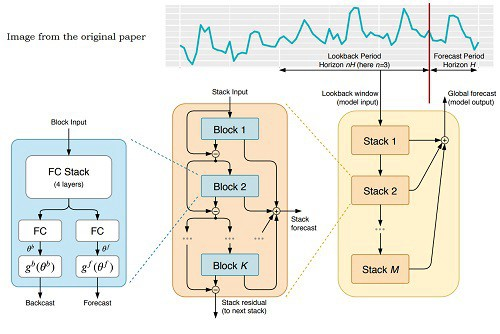

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):

  def __init__(self, input_size:int, theta_size:int, n_neurons:int, horizon:int, n_layers:int, **kwargs):

    super().__init__(**kwargs)

    self.input_size = input_size
    self.theta_size = theta_size
    self.n_neurons = n_neurons
    self.horizon = horizon
    self.n_layers = n_layers

    self.hidden_layer =  [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear")

  def call(self, inputs):

    x = inputs

    for layer in self.hidden_layer:

      x = layer(x)

    theta = self.theta_layer(x)

    backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:]

    return backcast, forecast

In [ ]:
# Lets test our block
n_beats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                            theta_size=WINDOW_SIZE + HORIZON, # backcast + forecast
                            horizon = HORIZON,
                            n_neurons = 128, 
                            n_layers = 4)

# Create a dummy input
dummy_input = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)

backcast, forecast = n_beats_block_layer(dummy_input)
# These are activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {backcast}")
print(f"Forecast: {forecast}")

Backcast: [[ 0.1312109   0.183297    1.1439569   0.01494303 -0.32428068 -0.2336111
  -0.4044428 ]]
Forecast: [[-0.33096844]]


In [ ]:
# Add windowed columns
gold_df_nbeats = gold_df.copy()

for i in range(WINDOW_SIZE):

  gold_df_nbeats[f"Value+{i+1}"] = gold_df_nbeats["Value"].shift(periods=i+1)

gold_df_nbeats.head()

,Value,Value+1,Value+2,Value+3,Value+4,Value+5,Value+6,Value+7
Date,,,,,,,,
1970-01-01,35.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-01,35.1,35.2,NaN,NaN,NaN,NaN,NaN,NaN
1970-07-01,35.4,35.1,35.2,NaN,NaN,NaN,NaN,NaN
1970-10-01,36.2,35.4,35.1,35.2,NaN,NaN,NaN,NaN
1971-01-01,37.4,36.2,35.4,35.1,35.2,NaN,NaN,NaN


In [ ]:
windows = gold_df_nbeats.dropna().drop("Value",axis=1).astype(np.float32)
labels = gold_df_nbeats.dropna()["Value"]

split_size = int(0.8 * len(windows))

train_windows, train_labels = windows[:split_size], labels[:split_size]
test_windows, test_labels = windows[split_size:], labels[split_size:]

In [ ]:
train_windows.shape

(8624, 7)

In [ ]:
x_train = tf.data.Dataset.from_tensor_slices(train_windows)
y_train = tf.data.Dataset.from_tensor_slices(train_labels)

train_dataset = tf.data.Dataset.zip((x_train, y_train))

x_test = tf.data.Dataset.from_tensor_slices(test_windows)
y_test = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((x_test, y_test))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON

## Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer
2. Create an input layer for the N-BEATS stack
3. Make the initial backcast and forecasts for the model with the layer created in
4. Use for loop to create stacks of block layers
5. Use the "NBeatsBlock" class within for loop in (4) to create blocks which return backcasts and block-level forecasts 
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using "tf.keras.Model()"
8. Compile the model with MAE loss and Adam optimizer
9. Fit the N-BEATS model for 5000 epochs and since it fitting for so many epochs, we will use a couple of callbacks:
* Early stopping - because the model will be training for so long, we will stop early if it stops improving
* Reduce LR on Plateau - reduce the learning rate each time

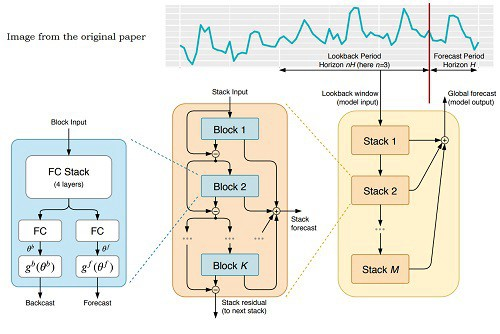

In [ ]:
# 1. Setup an instance of the N-beats block layer
n_beats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  n_neurons=N_NEURONS,
                                  horizon=HORIZON,
                                  n_layers=N_LAYERS)

# 2. Create an input layer for the N-BEATS stack
stack_inputs = tf.keras.layers.Input(shape=INPUT_SIZE)

# 3. Make the initial backcast and forecasts for the model with the layer created in 
residuals, forecasts = n_beats_block_layer(stack_inputs)

# 4. Use for loop to create stacks of block layers
for _ in range(N_STACKS-1):

  # 5. Use the "NBeatsBlock" class within for loop in (4) to create blocks which return backcasts and block-level forecasts 
  backcasts, block_forecasts = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  n_neurons=N_NEURONS,
                                  horizon=HORIZON,
                                  n_layers=N_LAYERS)(residuals)

  # 6. Create the double residual stacking using subtract and add layers
  residuals = tf.keras.layers.subtract([residuals, backcasts])
  forecasts = tf.keras.layers.add([forecasts,block_forecasts])

# 7. Put the model inputs and outputs together using "tf.keras.Model()"
n_beats_model = tf.keras.models.Model(inputs=stack_inputs, outputs=forecasts)

# 8. Compile the model with MAE loss and Adam optimizer
n_beats_model.compile(loss=tf.keras.losses.mape,
                      optimizer=tf.keras.optimizers.Adam())

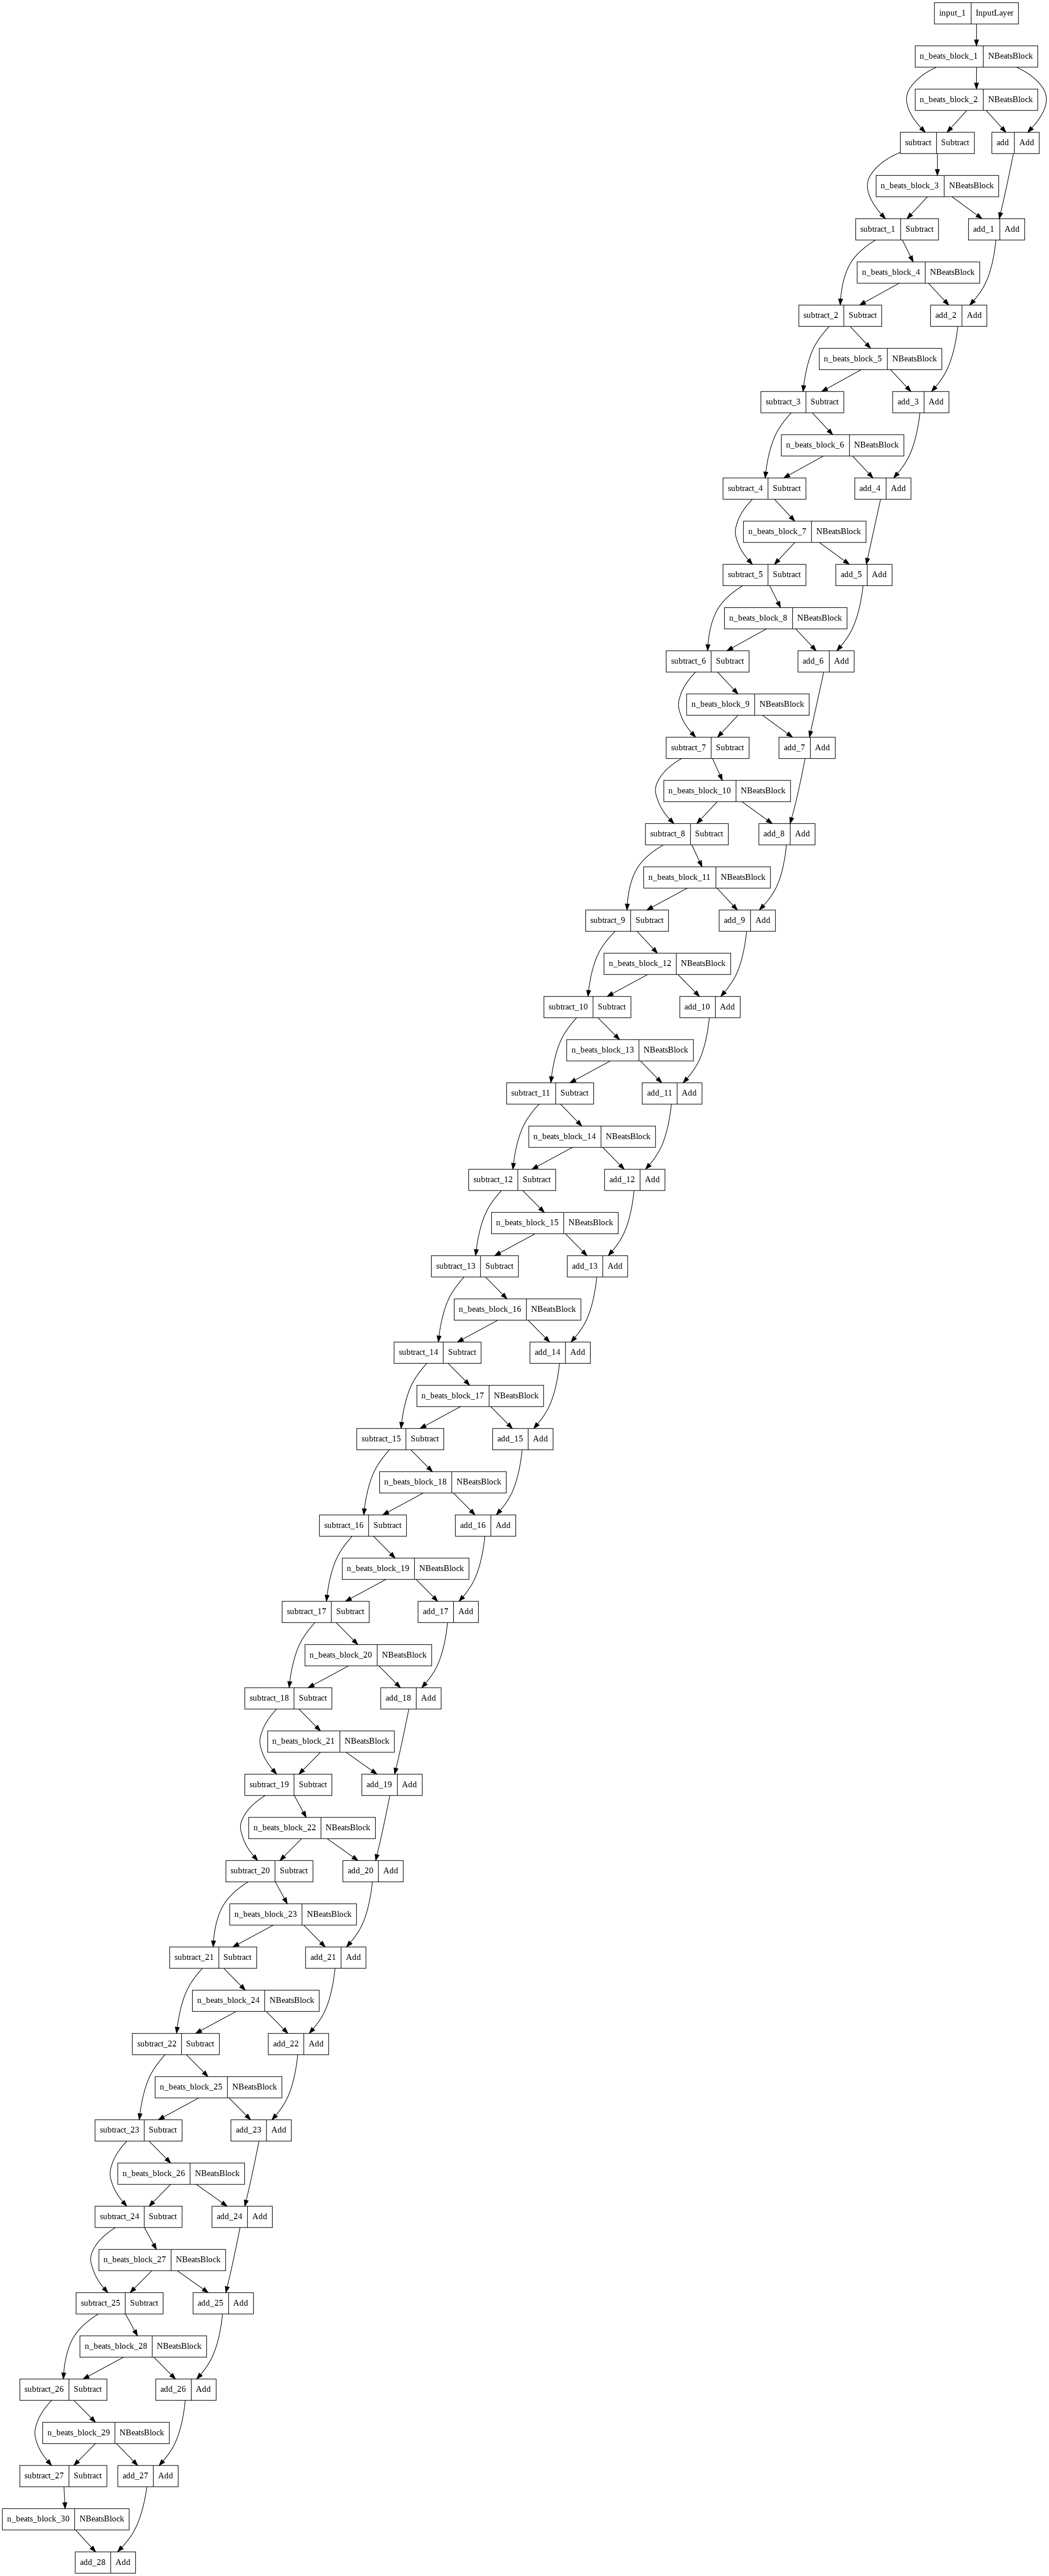

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(n_beats_model)

In [ ]:
# 9. Fit the N-BEATS model for 5000 epochs and since it fitting for so many epochs, we will use a couple of callbacks:
n_beats_model.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=200,restore_best_weights=True)])

Epoch 1/5000
270/270 [==============================] - 23s 32ms/step - loss: 6.5042 - val_loss: 3.6570
Epoch 2/5000
270/270 [==============================] - 8s 31ms/step - loss: 3.0292 - val_loss: 3.5342
Epoch 3/5000
270/270 [==============================] - 7s 26ms/step - loss: 2.4820 - val_loss: 3.7833
Epoch 4/5000
270/270 [==============================] - 7s 27ms/step - loss: 2.4342 - val_loss: 1.5497
Epoch 5/5000
270/270 [==============================] - 7s 27ms/step - loss: 2.3437 - val_loss: 0.8687
Epoch 6/5000
270/270 [==============================] - 7s 26ms/step - loss: 2.3010 - val_loss: 6.0628
Epoch 7/5000
270/270 [==============================] - 7s 26ms/step - loss: 2.1542 - val_loss: 1.9382
Epoch 8/5000
270/270 [==============================] - 7s 27ms/step - loss: 1.9127 - val_loss: 0.8117
Epoch 9/5000
270/270 [==============================] - 7s 27ms/step - loss: 2.0640 - val_loss: 2.3990
Epoch 10/5000
270/270 [==============================] - 8s 29ms/step - 

In [ ]:
n_beats_model.evaluate(test_dataset)

68/68 [==============================] - 1s 10ms/step - loss: 0.6920


0.6920360326766968

In [ ]:
predictions = n_beats_model.predict(test_windows)
predictions

array([[1715.4749],
       [1702.9751],
       [1663.937 ],
       ...,
       [1656.7516],
       [1650.7423],
       [1592.9697]], dtype=float32)

In [ ]:
n_beats_results = evaluate_preds(test_labels, predictions)
n_beats_results

{'MAE': 8.992376,
 'MAPE': 0.6685456,
 'MASE': 1.0583785,
 'MSE': 24629.494,
 'RMSE': 156.93787}

In [ ]:
baseline_results

{'MAE': 8.848064,
 'MAPE': 0.65682924,
 'MASE': 1.0413933,
 'MSE': 24253.674,
 'RMSE': 155.73592}

# 5. Ensemble Model

In [ ]:
def ensemble_preds(models,test_dataset):

  ensemble_results = []

  for model in models:

    predictions = model.predict(test_dataset)

    ensemble_results.append(predictions)

  return np.median(ensemble_results, axis=0)

In [ ]:
models = [model_baseline, conv1d_model, lstm_model, n_beats_model]
preds = ensemble_preds(models, test_windows)

ensemble_results = evaluate_preds(test_labels, preds)
ensemble_results

{'MAE': 8.906895,
 'MAPE': 0.66151345,
 'MASE': 1.0483176,
 'MSE': 24404.959,
 'RMSE': 156.22086}

In [ ]:
all_results = pd.DataFrame({"baseline_dense":baseline_results,
               "Conv1D":conv1d_model_results,
               "LSTM":lstm_results,
               "N-Beats":n_beats_results,
               "Ensemble":ensemble_results})
all_results = all_results.transpose()
all_results

,MAE,MSE,RMSE,MAPE,MASE
baseline_dense,8.848064,24253.673828,155.735916,0.656829,1.041393
Conv1D,8.873897,24332.164062,155.987701,0.658372,1.044434
LSTM,8.992376,24629.494141,156.937866,0.668546,1.058378
N-Beats,8.992376,24629.494141,156.937866,0.668546,1.058378
Ensemble,8.906895,24404.958984,156.220856,0.661513,1.048318


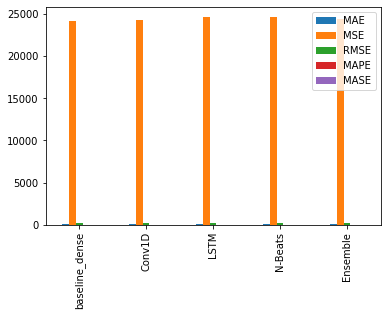

In [ ]:
all_results.plot(kind="bar")

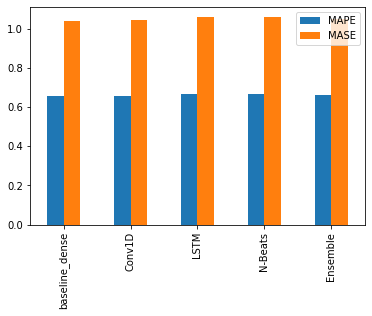

In [ ]:
#Without mae,mse and rmse
all_results_without_mse_and_rmse = all_results.drop(["MAE","MSE","RMSE"],axis=1)
all_results_without_mse_and_rmse.plot(kind="bar")